## Step 1: Setup
We first install PySpark and create a SparkSession for our project.


In [1]:
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Movie-Capstone").getOrCreate()
sc = spark.sparkContext


## Step 2: Prepare Data
We create three DataFrames: **Users, Movies, Ratings**.  
These will act as our sample dataset for analysis.


In [2]:
# Users Data
users_data = [
    (1, "Rahul", 25, "Bangalore"),
    (2, "Priya", 30, "Delhi"),
    (3, "Aman", 22, "Hyderabad"),
    (4, "Sneha", 28, "Chennai"),
    (5, "Arjun", 35, "Mumbai")
]
users_cols = ["user_id", "name", "age", "city"]
users_df = spark.createDataFrame(users_data, users_cols)

# Movies Data
movies_data = [
    (101, "Inception", "Sci-Fi", 2010),
    (102, "Avengers", "Action", 2012),
    (103, "3 Idiots", "Comedy", 2009),
    (104, "Dangal", "Drama", 2016),
    (105, "Interstellar", "Sci-Fi", 2014)
]
movies_cols = ["movie_id", "title", "genre", "year"]
movies_df = spark.createDataFrame(movies_data, movies_cols)

# Ratings Data
ratings_data = [
    (1, 101, 5),
    (2, 101, 4),
    (1, 102, 3),
    (3, 103, 4),
    (4, 104, 5),
    (2, 103, 5),
    (5, 105, 4),
    (6, 101, 5)  # Rating from non-existent user
]
ratings_cols = ["user_id", "movie_id", "rating"]
ratings_df = spark.createDataFrame(ratings_data, ratings_cols)


## Part A – DataFrame Basics
Basic operations on DataFrames:
1. Users older than 28  
2. Distinct movie genres  
3. Movies released after 2010


In [3]:
users_df.filter(users_df.age > 28).show()
movies_df.select("genre").distinct().show()
movies_df.filter(movies_df.year > 2010).show()


+-------+-----+---+------+
|user_id| name|age|  city|
+-------+-----+---+------+
|      2|Priya| 30| Delhi|
|      5|Arjun| 35|Mumbai|
+-------+-----+---+------+

+------+
| genre|
+------+
|Action|
|Sci-Fi|
| Drama|
|Comedy|
+------+

+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     102|    Avengers|Action|2012|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+



## Part B – Aggregations
We use groupBy and aggregation functions:
- Average age of users per city  
- Average rating per movie  
- Highest-rated movie in each genre


In [4]:
from pyspark.sql.functions import avg

users_df.groupBy("city").agg(avg("age")).show()
ratings_df.groupBy("movie_id").agg(avg("rating")).show()

ratings_movies = ratings_df.join(movies_df, "movie_id")
ratings_movies.groupBy("genre", "title").agg(avg("rating").alias("avg_rating")) \
    .orderBy("genre", "avg_rating", ascending=[True, False]).show()


+---------+--------+
|     city|avg(age)|
+---------+--------+
|Bangalore|    25.0|
|    Delhi|    30.0|
|  Chennai|    28.0|
|   Mumbai|    35.0|
|Hyderabad|    22.0|
+---------+--------+

+--------+-----------------+
|movie_id|      avg(rating)|
+--------+-----------------+
|     103|              4.5|
|     101|4.666666666666667|
|     102|              3.0|
|     104|              5.0|
|     105|              4.0|
+--------+-----------------+

+------+------------+-----------------+
| genre|       title|       avg_rating|
+------+------------+-----------------+
|Action|    Avengers|              3.0|
|Comedy|    3 Idiots|              4.5|
| Drama|      Dangal|              5.0|
|Sci-Fi|   Inception|4.666666666666667|
|Sci-Fi|Interstellar|              4.0|
+------+------------+-----------------+



## Part C – Joins
We perform joins to combine data:  
1. Ratings with Users  
2. Ratings with Movies  
3. Users with no ratings  
4. Movies with no ratings


In [5]:
ratings_users = ratings_df.join(users_df, "user_id")
ratings_users.show()

ratings_movies = ratings_df.join(movies_df, "movie_id")
ratings_movies.show()

users_df.join(ratings_df, "user_id", "left_anti").show()
movies_df.join(ratings_df, "movie_id", "left_anti").show()


+-------+--------+------+-----+---+---------+
|user_id|movie_id|rating| name|age|     city|
+-------+--------+------+-----+---+---------+
|      1|     101|     5|Rahul| 25|Bangalore|
|      1|     102|     3|Rahul| 25|Bangalore|
|      2|     101|     4|Priya| 30|    Delhi|
|      2|     103|     5|Priya| 30|    Delhi|
|      3|     103|     4| Aman| 22|Hyderabad|
|      4|     104|     5|Sneha| 28|  Chennai|
|      5|     105|     4|Arjun| 35|   Mumbai|
+-------+--------+------+-----+---+---------+

+--------+-------+------+------------+------+----+
|movie_id|user_id|rating|       title| genre|year|
+--------+-------+------+------------+------+----+
|     101|      1|     5|   Inception|Sci-Fi|2010|
|     101|      2|     4|   Inception|Sci-Fi|2010|
|     101|      6|     5|   Inception|Sci-Fi|2010|
|     102|      1|     3|    Avengers|Action|2012|
|     103|      3|     4|    3 Idiots|Comedy|2009|
|     103|      2|     5|    3 Idiots|Comedy|2009|
|     104|      4|     5|      Dan

## Part D – SQL Queries
We register DataFrames as SQL views and run queries:  
- Top 2 cities by ratings count  
- Users with 5-star ratings  
- Most popular genre by number of ratings


In [6]:
users_df.createOrReplaceTempView("users")
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")

spark.sql("""
SELECT u.city, COUNT(r.rating) as total_ratings
FROM users u
JOIN ratings r ON u.user_id = r.user_id
GROUP BY u.city
ORDER BY total_ratings DESC
LIMIT 2
""").show()

spark.sql("""
SELECT DISTINCT u.name
FROM users u
JOIN ratings r ON u.user_id = r.user_id
WHERE r.rating = 5
""").show()

spark.sql("""
SELECT m.genre, COUNT(r.rating) as total_ratings
FROM movies m
JOIN ratings r ON m.movie_id = r.movie_id
GROUP BY m.genre
ORDER BY total_ratings DESC
LIMIT 1
""").show()


+---------+-------------+
|     city|total_ratings|
+---------+-------------+
|Bangalore|            2|
|    Delhi|            2|
+---------+-------------+

+-----+
| name|
+-----+
|Sneha|
|Priya|
|Rahul|
+-----+

+------+-------------+
| genre|total_ratings|
+------+-------------+
|Sci-Fi|            4|
+------+-------------+



## Part E – File I/O
Save and reload DataFrames in different formats:  
- Save Ratings as CSV  
- Save Movies as JSON


In [7]:
ratings_df.write.csv("/content/ratings_csv", header=True, mode="overwrite")
ratings_csv = spark.read.csv("/content/ratings_csv", header=True, inferSchema=True)

movies_df.write.json("/content/movies_json", mode="overwrite")
movies_json = spark.read.json("/content/movies_json")


## Part F – Visualization
We convert PySpark DataFrames into Pandas and plot:  
1. Average rating per genre (Bar chart)  
2. Number of ratings per year (Line chart)  
3. Age vs Average rating (Scatter plot)


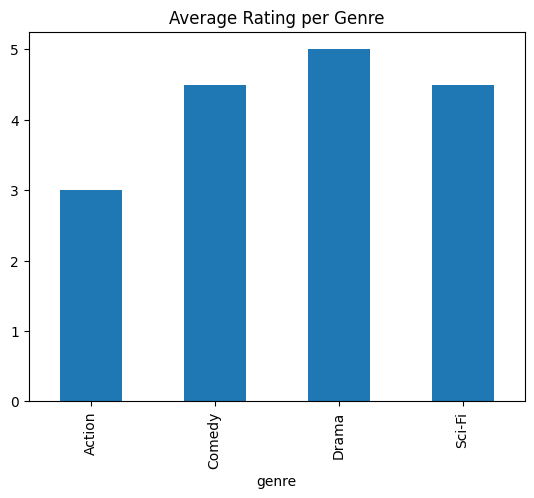

In [9]:
import matplotlib.pyplot as plt

# Convert to Pandas
ratings_movies_pd = ratings_movies.toPandas()
ratings_users_pd = ratings_users.toPandas()

# Average rating per genre
avg_rating_genre = ratings_movies_pd.groupby("genre")["rating"].mean()
avg_rating_genre.plot(kind="bar", title="Average Rating per Genre")
plt.show()


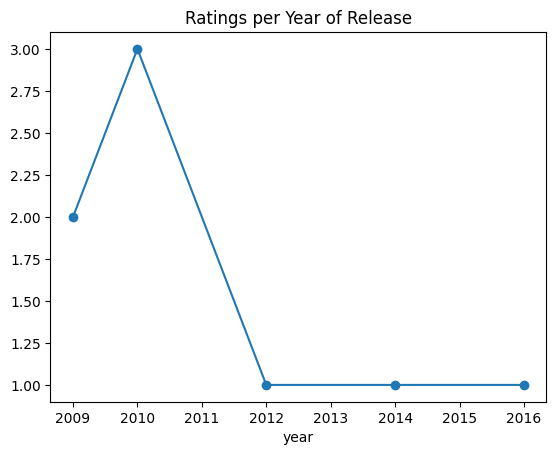

In [10]:
# Ratings per year of release
ratings_year = ratings_movies_pd.groupby("year")["rating"].count()
ratings_year.plot(kind="line", marker="o", title="Ratings per Year of Release")
plt.show()


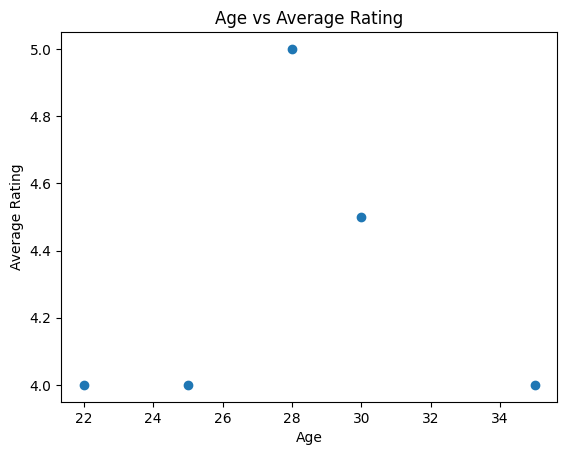

In [11]:
# Age vs Average Rating
age_rating = ratings_users_pd.groupby("age")["rating"].mean()
plt.scatter(age_rating.index, age_rating.values)
plt.title("Age vs Average Rating")
plt.xlabel("Age")
plt.ylabel("Average Rating")
plt.show()